In [8]:
import json
from collections import Counter, defaultdict, deque
import gc

import numpy as np
import pandas as pd
import glob
import time
from tqdm import tqdm

from sklearn import model_selection, metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgb
from scipy.stats import skew

import feather
import pickle
import h5py

from concurrent import futures
#import riiideducation

from trueskill import Rating, quality_1vs1, rate_1vs1, TrueSkill, global_env

In [2]:
question = pd.read_csv("/home/pocket/input/questions.csv")
question.head(2)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


<AxesSubplot:>

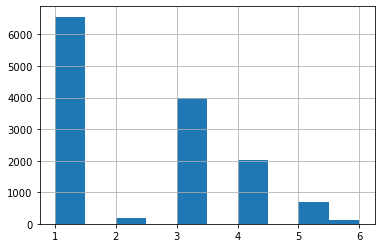

In [3]:
question["tags"].astype(str).apply(lambda x: len(x.split())).hist()

In [4]:
lecture = pd.read_csv("/home/pocket/input/lectures.csv")
lecture.head(2)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept


In [5]:
lecture = lecture.set_index("lecture_id")
lectures_dict = lecture.to_dict("index")

In [6]:
train = pd.read_feather("./final_train.feather")

In [7]:
#train["prior_question_had_explanation"].fillna(False, inplace=True)

In [8]:
#train["prior_question_had_explanation"] = train["prior_question_had_explanation"].astype(int)

In [9]:
# use_col = [
#     'row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
#     'task_container_id', 'user_answer', 'answered_correctly',
#     'prior_question_elapsed_time', 'prior_question_had_explanation',
# ]
# train[use_col].to_feather("./train_sorted_full2.feather")

In [10]:
print(train.columns)

# no lectures for now
#train = train[train["answered_correctly"] != -1]

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')


In [11]:
train.head(2)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,32933156,0,705741139,128,0,0,0,1,NaN,0
1,32933157,20666,705741139,7860,0,1,0,1,16000.0,0


In [12]:
class PocketCounter():
    def __init__(self):
        self.cnt = Counter()
        self.sum = Counter()
    
    def update(self, key, sum_val):
        self.cnt[key] += 1
        self.sum[key] += sum_val
        
    def get_mean(self, key):
        return (self.sum[key] / self.cnt[key]) if self.cnt[key] != 0 else np.nan
    
    
class PocketSessionCounter():
    def __init__(self):
        self.prev_ts = defaultdict(int)
        self.session_cnt = Counter()
        self.cnt = Counter()
        self.sum = Counter()
        
    def update_session(self, key, ts):
        if ts - self.prev_ts[key] > 3600*1000:
            self.session_cnt[key] += 1
            self.cnt[key] = 0
            self.sum[key] = 0
        self.prev_ts[key] = ts
        
    def update_ac(self, key, sum_val):
        self.cnt[key] += 1
        self.sum[key] += sum_val
        
    def get_mean(self, key):
        return (self.sum[key] / self.cnt[key]) if self.cnt[key] != 0 else np.nan
    
    
class PocketNunique():
    def __init__(self):
        self.val_set = defaultdict(set)
        self.repeat_cnt = Counter()
    
    def update(self, key, val):
        if val in self.val_set[key]:
            self.repeat_cnt[key] += 1
        self.val_set[key].add(val)
    
    def get_nunique(self, key):
        return len(self.val_set[key])
    
    def get_nunique_ratio(self):
        pass # doit in main loop
    
    def get_repeat_cnt(self, key):
        return self.repeat_cnt[key]  # or just cnt minus nunique?


class PocketRoller():
    def __init__(self, roll50=False):
        self.roll = defaultdict(self.get_deq20)
            
    def update(self, key, val):
        self.roll[key].append(val)
        
    def get_deq20(self):
        return deque(maxlen=20)
    
    def get_mean(self, key):
        return sum(self.roll[key]) / len(self.roll[key]) if len(self.roll[key]) != 0 else np.nan
    

class PocketTimestamp():
    def __init__(self):
        self.prev_ts = {}
        self.prev_td = 0
        self.td = 0
    
    def update(self, key, ts):
        td = self.prev_ts.get(key, np.nan) - ts
        if td < 0 or np.isnan(td):
            self.td = td
            self.prev_td = td
        else:
            self.td = self.prev_td
        self.prev_ts[key] = ts
        
    def update_only_ts(self, key, ts):
        self.prev_ts[key] = ts
        
    def get_simple_td(self, key, ts):
        return self.prev_ts.get(key, np.nan) - ts

    
class PocketTSRoller():
    def __init__(self):
        self.roll = defaultdict(self.get_deq)
    
    def update(self, key, val):
        if len(self.roll[key]) == 0:
            self.roll[key].append(val)
        
        if val - self.roll[key][-1] != 0:
            self.roll[key].append(val)
        else:
            pass
    
    def get_prev_t(self, key, t):
        if len(self.roll[key]) < t:
            return np.nan
        else:
            return self.roll[key][-t]
        
    def get_deq(self):
        return deque(maxlen=10)

    
class PocketTrueskill():
    def __init__(self):      
        self.env = TrueSkill(mu=0.5, sigma=0.164486, beta=0.05, tau=0.00164, draw_probability=0)
        self.u_trueskill = {}
        
    def get_mu(self, uid):
        if uid in self.u_trueskill.keys():
            return self.u_trueskill[uid].mu
        else:
            return np.nan
        
    def get_sigma(self, uid):
        if uid in self.u_trueskill.keys():
            return self.u_trueskill[uid].sigma
        else:
            return np.nan
    
    def update(self, uid, q_mean_ac, ac):
        self.init_user(uid)
        
        u_trueskill = self.u_trueskill[uid]
        q_trueskill = self.env.create_rating(mu=1-q_mean_ac)
        
        if ac > 0:
            new_u_rate, new_q_rate = rate_1vs1(u_trueskill, q_trueskill)
        else:
            new_u_rate, new_q_rate = rate_1vs1(q_trueskill, u_trueskill)
        self.u_trueskill[uid] = new_u_rate
    
    def init_user(self, uid):
        if uid not in self.u_trueskill.keys():
            self.u_trueskill[uid] = self.env.create_rating()
            
    def win_probability(self, team1, team2):
        delta_mu = team1.mu - team2.mu
        sum_sigma = sum([team1.sigma ** 2, team2.sigma ** 2])
        size = 2
        denom = math.sqrt(size * (0.05 * 0.05) + sum_sigma)
        return self.env.cdf(delta_mu / denom)
    
    
class PocketElo():
    def __init__(self):
        self.u_theta = {}
        self.u_theta50 = defaultdict(self.get_deq50)
        self.u_cnt = {}
        self.left_asymptote = 0.25
        
    def get_theta(self, uid):
        if uid not in self.u_theta.keys():
            return np.nan
        else:
            return self.u_theta[uid]
        
    def get_mean50(self, uid):
        if uid not in self.u_theta50.keys():
            return np.nan
        else:
            return np.mean(self.u_theta50[uid])
        
    def get_max50(self, uid):
        if uid not in self.u_theta50.keys():
            return np.nan
        else:
            return np.max(self.u_theta50[uid])
        
    def get_min50(self, uid):
        if uid not in self.u_theta50.keys():
            return np.nan
        else:
            return np.min(self.u_theta50[uid])
        
    def get_deq50(self):
        return deque(maxlen=50)
        
    def init_user(self, uid):
        if uid not in self.u_theta.keys():
            self.u_theta[uid] = 0
            self.u_cnt[uid] = 0
    
    def update(self, uid, ac, beta):
        self.init_user(uid)
        
        theta, cnt = self.u_theta[uid], self.u_cnt[uid]
        new_theta = self.get_new_theta(ac, beta, theta, cnt)
        self.u_theta[uid] = new_theta
        self.u_cnt[uid] += 1
        self.u_theta50[uid].append(new_theta)
            
    def get_new_theta(self, ac, beta, theta, cnt):
        return theta + self.learning_rate_theta(cnt) * (ac - self.ac_prob(theta, beta))
    
    def learning_rate_theta(self, cnt):
        return max(0.3 / (1 + 0.01 * cnt), 0.04)
    
    def ac_prob(self, theta, beta):
        return self.left_asymptote + (1 - self.left_asymptote) * self.sigmoid(theta - beta)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [50]:
class PocketFeatureFactory():
    def __init__(self, is_train, contents_dict):
        self.u_ac = PocketCounter()
        self.uc_ac = PocketCounter()
        self.u_qm = PocketCounter()
        self.u_ac_roll = PocketRoller()
        self.u_ts = PocketTimestamp()
        self.uc_ts = PocketTimestamp()
        self.u_ok_qm = PocketCounter()
        self.u_ng_qm = PocketCounter()
        self.up_ac = PocketCounter()
        self.ulr_ac = PocketCounter()
        self.uca_ac = PocketCounter()
        self.ut_ac = PocketCounter()
        self.ul_ts = PocketTimestamp()
        self.u_ts_wl = PocketTimestamp()
        self.u_ts_roll = PocketTSRoller()
        
        self.u_elo = PocketElo()
        self.u_rate = PocketCounter()
        
        self.ulr_elo = PocketElo()
        self.u_qelo = PocketCounter()
        self.u_ok_qelo = PocketCounter()
        self.u_ng_qelo = PocketCounter()
        self.u_rate_elo = PocketCounter()
        
        self.u_ok_ts = PocketTimestamp()
        self.u_ng_ts = PocketTimestamp()
        self.u_sess_ac = PocketSessionCounter()
        
        self.uc1_ac = PocketCounter()
        self.uc2_ac = PocketCounter()
        self.uc3_ac = PocketCounter()
        self.uc4_ac = PocketCounter()
        
        self.uc_nuni = PocketNunique()
        
        self.contents_dict = contents_dict
        self.is_train = is_train
        
    def get_row_tuple(self, row):
        ts, uid, cid, tcid = int(row[1]), int(row[2]), int(row[3]), int(row[5])
        if self.is_train:
            et = row[8]
            pqhe = row[9]
        else:
            et = row[6]
            pqhe = row[7]
            
        return (ts, uid, cid, tcid, et, pqhe)
        
    def unpack_row(self, row):
        (ts, uid, cid, tcid, et, pqhe) = self.get_row_tuple(row)
        
        contents = self.contents_dict[cid]
        qm = contents["q_ac_mean"]
        bid = contents["bundle_id"]
        part = contents["part"]
        ca = contents["correct_answer"]
        lr = part < 5
        tags = contents["tags"].split()
        
        ucid = (uid, cid)
        utcid = (uid, tcid)
        ubid = (uid, bid)
        upid = (uid, part)
        ulr = (uid, lr)
        uca = (uid, ca)
        return (ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca)
    
    def do_lecture(self, row):
        ts, uid, cid = int(row[1]), int(row[2]), int(row[3])
        self.ul_ts.update_only_ts(uid, ts)
        self.u_ts_wl.update_only_ts(uid, ts)
        self.u_ts_roll.update(uid, ts)
    
    def update_ac_values(self, prev_rows, prev_acs, prev_uas):
        for i, row in enumerate(prev_rows):
            self.update_ac_value(row, prev_acs[i], prev_uas[i])
    
    def update_ac_value(self, row, prev_ac, prev_ua):
        ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca = self.unpack_row(row)
        contents = self.contents_dict[cid]
        beta = contents["elo_beta"]
        c1 = contents["raw_clusters"]
        c2 = contents["nmf_clusters"]
        c3 = contents["lda_clusters"]
        c4 = contents["lda_argmax"]
        uc1, uc2, uc3, uc4 = (uid, c1), (uid, c2), (uid, c3), (uid, c4)
        self.uc1_ac.update(uc1, prev_ac)
        self.uc2_ac.update(uc2, prev_ac)
        self.uc3_ac.update(uc3, prev_ac)
        self.uc4_ac.update(uc4, prev_ac)
        
        self.u_ac.update(uid, prev_ac)
        self.uc_ac.update(ucid, prev_ac)
        self.up_ac.update(upid, prev_ac)
        self.ulr_ac.update(ulr, prev_ac)
        self.uca_ac.update(uca, prev_ac)
        self.u_ac_roll.update(uid, prev_ac)
        self.u_sess_ac.update_ac(uid, prev_ac)

        for tag in tags:
            ut = (uid, tag)
            self.ut_ac.update(ut, prev_ac)

        if prev_ac > 0.5:
            self.u_ok_qm.update(uid, qm)
            self.u_rate.update(uid, contents["q_ok_uac_mean"])
            self.u_ok_qelo.update(uid, beta)
            self.u_rate_elo.update(uid, contents["q_ok_elo_mean"])
            self.u_ok_ts.update_only_ts(uid, ts)
        else:
            self.u_ng_qm.update(uid, qm)
            self.u_ng_qelo.update(uid, beta)
            self.u_rate.update(uid, contents["q_ng_uac_mean"])
            self.u_rate_elo.update(uid, contents["q_ng_elo_mean"])
            self.u_ng_ts.update_only_ts(uid, ts)
        
        self.u_elo.update(uid, prev_ac, beta)
        self.ulr_elo.update(ulr, prev_ac, beta)

    def make_row(self, row, data_list):
        ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca = self.unpack_row(row)

        output = {}
        output["row_id"] = int(row[0])
        output["user_id"] = uid
        if self.is_train:
            output["ac"] = int(row[7])
        output["et"] = et
        
        contents = self.contents_dict[cid]
        content_col = [
            "q_ac_mean", "q_ac_cnt", "q_et_mean", "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
            "part", "correct_answer",
            "q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_mean", "q_ng_uac_std",
            "elo_beta",
            "q_elo_mean", "b_elo_mean", "q_ok_elo_mean", "q_ok_elo_std", "q_ng_elo_mean", "q_ng_elo_std",
            "raw_clusters", "nmf_clusters", "lda_clusters", "lda_argmax",
            "q_next_et_mean", "q_next_et_std", "q_next_pqhe_mean",
            "q_mu", "q_sigma",

        ]
        nn_col = [f"nn_svd{i}" for i in range(10)]
        #w2v_col = [f"w2v_svd{i}" for i in range(10)]
        content_col += nn_col
        #content_col += w2v_col
        
        for c in content_col:
            output[c] = contents[c]
            
        self.u_ts.update(uid, ts)
        self.uc_ts.update(ucid, ts)
        self.u_ts_wl.update(uid, ts)
        output["u_td"] = self.u_ts.td
        output["uc_td"] = self.uc_ts.td
        output["u_td_wl"] = self.u_ts_wl.td
        output["ul_td"] = self.ul_ts.get_simple_td(uid, ts)

        self.u_qm.update(uid, qm)
        output["u_cnt"] = self.u_qm.cnt[uid]
        output["u_ac_cnt"] = self.u_ac.cnt[uid]
        output["u_ac_mean"] = self.u_ac.get_mean(uid)
        output["uc_ac_cnt"] = self.uc_ac.cnt[ucid]
        output["uc_ac_mean"] = self.uc_ac.get_mean(ucid)
        output["uca_ac_mean"] = self.uca_ac.get_mean(uca)
        output["u_qm_mean"] = self.u_qm.get_mean(uid)
        output["up_ac_cnt"] = self.up_ac.cnt[upid]
        output["up_ac_mean"] = self.up_ac.get_mean(upid)
        output["ulr_ac_mean"] = self.ulr_ac.get_mean(ulr)
        output["u_ok_qm_mean"] = self.u_ok_qm.get_mean(uid)
        output["u_ng_qm_mean"] = self.u_ng_qm.get_mean(uid)
        output["u_ac_mean20"] = self.u_ac_roll.get_mean(uid)
        
        output["u_rate"] = self.u_rate.get_mean(uid)
        output["u_elo_theta"] = self.u_elo.get_theta(uid)
        
        self.u_qelo.update(uid, contents["elo_beta"])
        output["u_qelo_mean"] = self.u_qelo.get_mean(uid)
        output["ulr_elo_mean"] = self.ulr_elo.get_theta(ulr)
        output["u_ok_qelo_mean"] = self.u_ok_qelo.get_mean(uid)
        output["u_ng_qelo_mean"] = self.u_ng_qelo.get_mean(uid)
        output["u_rate_elo"] = self.u_rate_elo.get_mean(uid)
        output["u_elo_theta50"] = self.u_elo.get_theta50(uid)
        
        c1 = contents["raw_clusters"]
        c2 = contents["nmf_clusters"]
        c3 = contents["lda_clusters"]
        c4 = contents["lda_argmax"]
        uc1, uc2, uc3, uc4 = (uid, c1), (uid, c2), (uid, c3), (uid, c4)
        output["uc1_ac"] = self.uc1_ac.get_mean(uc1)
        output["uc2_ac"] = self.uc2_ac.get_mean(uc2)
        output["uc3_ac"] = self.uc3_ac.get_mean(uc3)
        output["uc4_ac"] = self.uc4_ac.get_mean(uc4)
        
        self.uc_nuni.update(uid, cid)
        output["u_c_nunique"] = self.uc_nuni.get_nunique(uid)
        output["u_c_nunique_ratio"] = output["u_c_nunique"] / output["u_cnt"] * 100
        output["u_c_repeat_cnt"] = self.uc_nuni.get_repeat_cnt(uid)
        
        n = max(10-output["u_cnt"], 0)
        output["u_ac_mean_smooth"] = (n*0.5095/10) + ((10-n)*output["u_ac_mean"]/10) 
        
        self.u_sess_ac.update_session(uid, ts)
        output["u_ses_ac_mean"] = self.u_sess_ac.get_mean(uid)
        output["u_ses_cnt"] = self.u_sess_ac.session_cnt[uid]
        output["uses_cnt"] = self.u_sess_ac.cnt[uid]
        
        
        if len(self.u_ac_roll.roll[uid]) < 1:
            output["uac_prev1"] = np.nan
        else:
            output["uac_prev1"]= self.u_ac_roll.roll[uid][-1]
        if len(self.u_ac_roll.roll[uid]) < 2:
            output["uac_prev2"] = np.nan
        else:
            output["uac_prev2"]= self.u_ac_roll.roll[uid][-2]
        
        up1 = self.u_ts_roll.get_prev_t(uid, 1)
        up2 = self.u_ts_roll.get_prev_t(uid, 2)
        up3 = self.u_ts_roll.get_prev_t(uid, 3)
        up4 = self.u_ts_roll.get_prev_t(uid, 4)
        up5 = self.u_ts_roll.get_prev_t(uid, 5)
        up6 = self.u_ts_roll.get_prev_t(uid, 6)
        up7 = self.u_ts_roll.get_prev_t(uid, 7)
        up8 = self.u_ts_roll.get_prev_t(uid, 8)
        up9 = self.u_ts_roll.get_prev_t(uid, 9)
        up10 = self.u_ts_roll.get_prev_t(uid, 10)
        output["u_td_tp1"] = ts - up1
        output["u_td_p1p2"] = up1 - up2
        output["u_td_p2p3"] = up2 - up3
        output["u_td_p3p4"] = up3 - up4
        output["u_td_p4p5"] = up4 - up5
        output["u_td_p5p6"] = up5 - up6
        output["u_td_p6p7"] = up6 - up7
        output["u_td_p7p8"] = up7 - up8
        output["u_td_p8p9"] = up8 - up9
        output["u_td_p9p10"] = up9 - up10
        self.u_ts_roll.update(uid, ts)
        
        #temp_b_cnt = row[10]
        #output["u_td_final"] = output["u_td_wl"] / temp_b_cnt #+0.13pt
        #output["ub_td_final"] = output["ub_td"] / temp_b_cnt
        
        ut_sum = 0
        ut_cnt = 0
        ut_mean = []
        for tag in tags:
            ut = (uid, tag)
            ut_sum += self.ut_ac.sum[ut]
            ut_cnt += self.ut_ac.cnt[ut]
            if self.ut_ac.cnt[ut] != 0:
                ut_mean.append(self.ut_ac.get_mean(ut))
        output["ut_ac_mean"] = (ut_sum / ut_cnt) if ut_cnt != 0 else np.nan
        output["ut_ac_mean2"] = sum(ut_mean) / len(ut_mean) if len(ut_mean) != 0 else np.nan
        
        
        output["u_ok_ts"] = self.u_ok_ts.get_simple_td(uid, ts)
        output["u_ng_ts"] = self.u_ng_ts.get_simple_td(uid, ts)

        data_list.append(output)
        return data_list


In [51]:
class PocketFFUtil():
    def __init__(self):
        pass
    
    def merge(self, ff1, ff2):
        counters = [
            "u_ac", "uc_ac", "u_qm", "u_ok_qm", "u_ng_qm",
            "up_ac", "ulr_ac", "uca_ac", "ut_ac",
            "u_rate",
        ]
        for counter in counters:
            c1 = getattr(ff1, counter)
            c2 = getattr(ff2, counter)
            c1.cnt.update(c2.cnt)
            c1.sum.update(c2.sum)
        
        timestamps = [
            "u_ts", "uc_ts", "ul_ts", "u_ts_wl"
        ]
        for timestamp in timestamps:
            ts1 = getattr(ff1, timestamp)
            ts2 = getattr(ff2, timestamp)
            ts1.prev_ts.update(ts2.prev_ts)
        
        rolls = ["u_ac_roll", "u_ts_roll"]
        for r in rolls:
            r1 =  getattr(ff1, r)
            r2 =  getattr(ff2, r)
            r1.roll.update(r2.roll)
            
        rates = ["u_elo"]
        for r in rates:
            r1 = getattr(ff1, r)
            r2 = getattr(ff2, r)
            r1.u_theta.update(r2.u_theta)
            r1.u_cnt.update(r2.u_cnt)
        
        return ff1
        
    def to_file(self, ff, suffix):
        uid_set, uc_dict, ut_dict = self.make_ins_dict(ff)
        
        prefix = "./temp_files"
        day = "1226"
        
        with h5py.File(f"{prefix}/uc_dict_{day}_{suffix}.hdf5", "w") as f:   
            for (uid, l) in tqdm(uc_dict.items()):
                f.create_dataset(str(uid), data=l)
                
        with h5py.File(f"{prefix}/ut_dict_{day}_{suffix}.hdf5", "w") as f:   
            for (uid, l) in tqdm(ut_dict.items()):
                f.create_dataset(str(uid), data=l)
                
#         with open(f"./uid_set_1213_{suffix}.pkl", "wb") as handle:
#             pickle.dump(uid_set, handle, pickle.HIGHEST_PROTOCOL)
        
        ff = self.del_filed_attributes(ff)
        with open(f"{prefix}/ff_{day}_{suffix}.pkl", "wb") as handle:
            pickle.dump(ff, handle, pickle.HIGHEST_PROTOCOL)
            
    def make_ins_dict(self, ff):
        uid_set = set()
        uc_dict, ut_dict = {}, {}
        #print(len(ff.ub_ac), len(ff.ub_ts), len(ff.uc_ac), len(ff.uc_ts))
        
        for k, ts in tqdm(ff.uc_ts.prev_ts.items()):
            (uid, cid) = k
            l = uc_dict.get(uid, [])
            ac_sum, ac_cnt = ff.uc_ac.sum.get(k, np.nan), ff.uc_ac.cnt.get(k, np.nan)
            new_data = [cid, ts, ac_sum, ac_cnt]
            l.append(new_data)
            uc_dict[uid] = l
            #uid_set.add(uid)
        for k, ts in tqdm(ff.ut_ac.sum.items()):
            (uid, tag) = k
            l = ut_dict.get(uid, [])
            ac_sum, ac_cnt = ff.ut_ac.sum.get(k, np.nan), ff.ut_ac.cnt.get(k, np.nan)
            new_data = [int(tag), ac_sum, ac_cnt]
            l.append(new_data)
            ut_dict[uid] = l
            #uid_set.add(uid)
        return uid_set, uc_dict, ut_dict
    
    def del_filed_attributes(self, ff):
        ff.uc_ac = PocketCounter()
        ff.uc_ts = PocketTimestamp()
        ff.ut_ac = PocketCounter()
        return ff
        

In [15]:
# content_clusters = pd.read_csv("./content_clusters.csv")
# content_clusters.head()

In [16]:
# with open("./elo-user.pkl", "rb") as handle:
#     elo_user = pickle.load(handle)
# elo_user_df = pd.DataFrame.from_dict(elo_user, orient="index")
# elo_user_df.reset_index(inplace=True)
# elo_user_df.columns = ["user_id", "theta", "u_cnt"]
# elo_user_df.head(2)
# content_train = train[train["answered_correctly"] != -1].copy()
# content_train["temp_uac"] = content_train.groupby("user_id")["answered_correctly"].transform("mean")
# # content_train["td"] = content_train.groupby("user_id")["timestamp"].diff()
# # content_train["td"] = content_train["timestamp"] - content_train.groupby("user_id")["timestamp"].shift()
# # content_train["td"] = content_train.groupby(["user_id", "task_container_id"])["td"].transform("max")
# # content_train["one"] = 1
# # content_train["temp_ucnt"] = content_train.groupby("user_id")["one"].cumsum()
# # content_train["temp_log_ucnt"] = np.log1p(content_train["temp_ucnt"])

# q_col = ["question_id", "bundle_id"]
# content_train = pd.merge(
#     content_train, question[q_col], left_on="content_id", right_on="question_id", how="left"
# )
# e_col = ["user_id", "theta"]
# content_train = pd.merge(
#     content_train, elo_user_df[e_col], on="user_id", how="left"
# )
# elo1 = content_train.groupby("content_id")["theta"].agg(["mean"])
# elo1.columns = ["q_elo_mean"]
# elo2 = content_train.groupby("bundle_id")["theta"].agg(["mean"])
# elo2.columns = ["b_elo_mean"]

# elo3 = content_train[content_train["answered_correctly"]==1]
# elo3 = elo3.groupby("content_id")["theta"].agg(["mean", "std"])
# elo3.columns = ["q_ok_elo_mean", "q_ok_elo_std"]

# elo4 = content_train[content_train["answered_correctly"]==0]
# elo4 = elo4.groupby("content_id")["theta"].agg(["mean", "std"])
# elo4.columns = ["q_ng_elo_mean", "q_ng_elo_std"]

In [17]:
# # content_train = train[train["answered_correctly"] != -1].copy()
# # content_train["temp_uac"] = content_train.groupby("user_id")["answered_correctly"].transform("mean")
# # # content_train["td"] = content_train.groupby("user_id")["timestamp"].diff()
# # # content_train["td"] = content_train["timestamp"] - content_train.groupby("user_id")["timestamp"].shift()
# # # content_train["td"] = content_train.groupby(["user_id", "task_container_id"])["td"].transform("max")
# # # content_train["one"] = 1
# # # content_train["temp_ucnt"] = content_train.groupby("user_id")["one"].cumsum()
# # # content_train["temp_log_ucnt"] = np.log1p(content_train["temp_ucnt"])

# # q_col = ["question_id", "bundle_id"]
# # content_train = pd.merge(
# #     content_train, question[q_col], left_on="content_id", right_on="question_id", how="left"
# # )
# # e_col = ["user_id", "theta"]
# # content_train = pd.merge(
# #     content_train, elo_user_df[e_col], on="user_id", how="left"
# # )



# # contents features
# # there are no new contents in the test, so we use part of the train as the pseudo-training set
# temp = content_train.groupby("content_id")["answered_correctly"].agg(["mean", "count"])
# temp.columns = ["q_ac_mean", "q_ac_cnt"]
# temp2 = content_train.groupby("content_id")["prior_question_elapsed_time"].agg(["mean", "count", "std"])
# temp2.columns = ["q_et_mean", "q_et_cnt", "q_et_std"]
# # temp3 = content_train.groupby("content_id")["td"].agg(["mean", "std", "min", "max", "skew"])
# # temp3.columns = ["q_td_mean", "q_td_std", "q_td_min", "q_td_max", "q_td_skew"]
# temp4 = content_train.groupby("bundle_id")["answered_correctly"].agg(["mean", "count"])
# temp4.columns = ["b_ac_mean", "b_ac_cnt"]

# temp6 = content_train[content_train["answered_correctly"]==1]
# temp6 = temp6.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# temp6.columns = ["q_ok_uac_mean", "q_ok_uac_std"]

# temp7 = content_train[content_train["answered_correctly"]==0]
# temp7 = temp7.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# temp7.columns = ["q_ng_uac_mean", "q_ng_uac_std"]

# # temp8 = content_train.groupby("content_id")["temp_ucnt"].agg(["mean", "std", "skew"])
# # temp8.columns = ["q_ucnt_mean", "q_ucnt_std", "q_ucnt_skew"]
# # temp9 = content_train.groupby("content_id")["temp_log_ucnt"].agg(["mean", "std", "skew"])
# # temp9.columns = ["q_lucnt_mean", "q_lucnt_std", "q_lucnt_skew"]
# # temp10 = content_train[content_train["temp_ucnt"]>10]
# # temp10 = temp10.groupby("content_id")["answered_correctly"].agg(["mean"])
# # temp10.columns = ["q_ex10_mean"]

# # temp11 = content_train[content_train["prior_question_had_explanation"]==True]
# # temp11 = temp11.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# # temp11.columns = ["q_pqhe_true_uac_mean", "q_pqhe_true_uac_std"]
# # temp12 = content_train[content_train["prior_question_had_explanation"]==False]
# # temp12 = temp12.groupby("content_id")["temp_uac"].agg(["mean", "std"])
# # temp12.columns = ["q_pqhe_false_uac_mean", "q_pqhe_false_uac_std"]

# temp13 = content_train.groupby("content_id")["user_id"].agg(["nunique", "count"])
# temp13.columns = ["q_u_nunique", "q_u_cnt"]
# temp13["q_u_unique_ratio"] = temp13["q_u_nunique"] / temp13["q_u_cnt"]

# # temp14 = content_train.groupby(["content_id", "user_answer"])["temp_uac"].agg(["count", "mean"])
# # temp14["count_sum"] = temp14.groupby(["content_id"])["count"].transform("sum")
# # temp14["cnt_ratio"] = temp14["count"] / temp14["count_sum"]
# # temp14.sort_values(["content_id", "count"], ascending=False, inplace=True)
# # temp14["one"] = 1
# # temp14["ans_order"] = temp14.groupby("content_id")["one"].cumsum()
# # temp14 = temp14.reset_index().pivot(index="content_id", columns="ans_order", values=["mean", "cnt_ratio"])
# # temp14.columns =[f"q_{s1}_ans{str(s2)}" for (s1,s2) in temp14.columns.tolist()]

# question["b_cnt"] = question.groupby("bundle_id")["question_id"].transform("count")
# q_col = ["question_id", "bundle_id", "part", "correct_answer", "tags", "b_cnt"]
# #q_col += [str(i) for i in range(188)]
# contents = pd.merge(question[q_col], temp, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp2, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp3, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp4, on="bundle_id", how="left")
# contents = pd.merge(contents, temp6, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp7, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp8, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp9, left_on="question_id", right_on="content_id", how="left")
# # contents = pd.merge(contents, temp10, left_on="question_id", right_on="content_id", how="left")
# #contents = pd.merge(contents, temp11, left_on="question_id", right_on="content_id", how="left")
# #contents = pd.merge(contents, temp12, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp13, left_on="question_id", right_on="content_id", how="left")
# #contents = pd.merge(contents, temp14, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, elo1, left_on="question_id", right_on="content_id", how="left")
# print(contents.head(2))
# print(contents.shape)
# merge_col = [
#     "question_id", "bundle_id", "part", "correct_answer", "tags",
#     "q_ac_mean", "q_ac_cnt", "q_et_mean",
#     "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
#     "q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_mean", "q_ng_uac_std",
# ]
# contents = contents[merge_col]
# contents["tags"].fillna("-1", inplace=True)

# contents = pd.merge(contents, elo1, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, elo2, on="bundle_id", how="left")
# contents = pd.merge(contents, elo3, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, elo4, left_on="question_id", right_on="content_id", how="left")
# merge_col += [
#     "q_elo_mean", "b_elo_mean", "q_ok_elo_mean", "q_ok_elo_std", "q_ng_elo_mean", "q_ng_elo_std"
# ]
# contents = contents[merge_col]

# contents = contents.set_index("question_id")
# contents_dict = contents.to_dict("index")
# print(len(contents_dict))



In [18]:
# edq_df = pd.read_csv("./temp_merge.csv")
# edq_df.head()

# merge_col = ["question_id", "count", "mean", "deployed_at"]
# contents_ed = pd.merge(contents, edq_df[merge_col], on="question_id", how="left") 

# cols = contents_ed.columns
# cols2 = list(cols)[:-3]
# cols2 =  cols2 + ["edq_count", "edq_mean", "deployed_at"]
# contents_ed.columns = cols2
# contents_ed = contents_ed.set_index("question_id")
# contents_ed.head(2)

In [19]:
# contents_dict = contents_ed.to_dict("index")

In [20]:
# with open("./contents_dict_full_1222.pkl", "wb") as handle:
#     pickle.dump(contents_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(len(contents_dict))

In [21]:
# with open("./contents_dict_full_1223.pkl", "rb") as handle:
#     contents_dict = pickle.load(handle)
# print(len(contents_dict))

In [22]:
# with open("./elo-item.pkl", "rb") as handle:
#     elo_item = pickle.load(handle)

In [23]:
# for k, v in contents_dict.items():
#     contents_dict[k]["elo_beta"] = elo_item[k]["beta"]

In [24]:
# contents_vec = pd.read_csv("./content_nn.csv")

In [25]:
# for row in contents_vec.values:
#     cid = row[0]
#     for j in range(20):
#         contents_dict[cid][f"nn_svd{j}"] = row[j+1]
#     contents_dict[cid]["nn_cluster"] = row[21]

In [26]:
# with open("./contents_dict_1229.pkl", "wb") as handle:
#     pickle.dump(contents_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(len(contents_dict))

In [27]:
with open("./contents_dict_1229.pkl", "rb") as handle:
    contents_dict = pickle.load(handle)
print(len(contents_dict))

13523


In [28]:
with open("./true_skill_q_rate_1231.pkl", "rb") as handle:
    q_rate = pickle.load(handle)
print(len(q_rate))

13523


In [29]:
q_rate

{0: trueskill.Rating(mu=21.523, sigma=0.781),
 1: trueskill.Rating(mu=21.445, sigma=1.135),
 2: trueskill.Rating(mu=22.373, sigma=0.787),
 3: trueskill.Rating(mu=22.979, sigma=1.292),
 4: trueskill.Rating(mu=23.672, sigma=0.791),
 5: trueskill.Rating(mu=21.732, sigma=0.797),
 6: trueskill.Rating(mu=16.563, sigma=1.259),
 7: trueskill.Rating(mu=21.388, sigma=0.788),
 8: trueskill.Rating(mu=22.945, sigma=0.790),
 9: trueskill.Rating(mu=22.140, sigma=0.793),
 10: trueskill.Rating(mu=21.244, sigma=1.786),
 11: trueskill.Rating(mu=19.830, sigma=0.806),
 12: trueskill.Rating(mu=23.647, sigma=0.912),
 13: trueskill.Rating(mu=22.874, sigma=0.839),
 14: trueskill.Rating(mu=22.653, sigma=0.790),
 15: trueskill.Rating(mu=22.956, sigma=0.789),
 16: trueskill.Rating(mu=23.229, sigma=0.784),
 17: trueskill.Rating(mu=22.804, sigma=0.785),
 18: trueskill.Rating(mu=19.277, sigma=0.807),
 19: trueskill.Rating(mu=21.708, sigma=1.481),
 20: trueskill.Rating(mu=16.909, sigma=0.956),
 21: trueskill.Rating(m

In [30]:
for k, v in q_rate.items():
    contents_dict[k]["q_mu"] = v.mu
    contents_dict[k]["q_sigma"] = v.sigma

In [31]:
# contents_vec = pd.read_csv("./content_w2v.csv")
# for row in contents_vec.values:
#     cid = row[0]
#     for j in range(20):
#         contents_dict[cid][f"w2v_svd{j}"] = row[j+1]

In [32]:
tag_cluster = pd.read_csv("./tag_cluster.csv")

In [33]:
tag_cluster.head(2)

,contents_id,raw_clusters,nmf_clusters,lda_clusters,lda_argmax
0,0,14,9,1,3
1,1,14,9,12,3


In [34]:
for row in tag_cluster.values:
    cid = row[0]
    contents_dict[cid]["raw_clusters"] = row[1]
    contents_dict[cid]["nmf_clusters"] = row[2]
    contents_dict[cid]["lda_clusters"] = row[3]
    contents_dict[cid]["lda_argmax"] = row[4]

In [35]:
content_train = train[train["answered_correctly"] != -1].copy()

In [36]:
content_train["next_et"] = content_train.groupby("user_id")["prior_question_elapsed_time"].shift(-1)
content_train["next_pqhe"] = content_train.groupby("user_id")["prior_question_had_explanation"].shift(-1)

temp = content_train.groupby("content_id")["next_et"].agg(["mean", "count", "std"])
temp.columns = ["q_next_et_mean", "q_next_et_cnt", "q_next_et_std"]
temp2 = content_train.groupby("content_id")["next_pqhe"].agg(["mean"])
temp2.columns = ["q_next_pqhe_mean"]

In [37]:
contents = pd.DataFrame.from_dict(contents_dict, orient="index")

In [38]:
contents.head(2)

,bundle_id,part,correct_answer,tags,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,...,nn_svd17,nn_svd18,nn_svd19,nn_cluster,q_mu,q_sigma,raw_clusters,nmf_clusters,lda_clusters,lda_argmax
0,0,1,0,51 131 162 38,0.907721,6903,21875.328125,6901,10519.116289,0.907721,...,-0.052895,-0.047862,0.010022,6.0,21.522950,0.780768,14,9,1,3
1,1,1,1,131 36 81,0.890646,7398,22091.626953,7398,10867.885630,0.890646,...,0.050018,-0.052557,0.025437,6.0,21.445019,1.134815,14,9,12,3


In [39]:
contents_merged = pd.merge(contents, temp, left_index=True, right_on="content_id")
contents_merged = pd.merge(contents_merged, temp2, left_index=True, right_on="content_id")

In [40]:
contents_merged.head(2)

,bundle_id,part,correct_answer,tags,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,...,q_mu,q_sigma,raw_clusters,nmf_clusters,lda_clusters,lda_argmax,q_next_et_mean,q_next_et_cnt,q_next_et_std,q_next_pqhe_mean
content_id,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,51 131 162 38,0.907721,6903,21875.328125,6901,10519.116289,0.907721,...,21.522950,0.780768,14,9,1,3,19693.703125,6892,8437.228477,0.952844
1,1,1,1,131 36 81,0.890646,7398,22091.626953,7398,10867.885630,0.890646,...,21.445019,1.134815,14,9,12,3,19320.742188,7386,10207.045255,0.981045


<AxesSubplot:xlabel='q_mu', ylabel='elo_beta'>

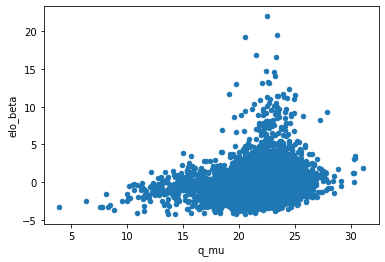

In [72]:
contents_merged[["q_mu", "elo_beta"]].plot(kind="scatter", x="q_mu", y="elo_beta")

In [74]:
contents_merged[["q_mu", "elo_beta", "q_ac_mean"]].corr()

,q_mu,elo_beta,q_ac_mean
q_mu,1.000000,0.192054,-0.193825
elo_beta,0.192054,1.000000,-0.926130
q_ac_mean,-0.193825,-0.926130,1.000000


In [41]:
contents_dict2 = contents_merged.to_dict("index")

In [42]:
print(contents_dict2[0])

{'bundle_id': 0, 'part': 1, 'correct_answer': 0, 'tags': '51 131 162 38', 'q_ac_mean': 0.9077212806026366, 'q_ac_cnt': 6903, 'q_et_mean': 21875.328125, 'q_et_cnt': 6901, 'q_et_std': 10519.116288983123, 'b_ac_mean': 0.9077212806026366, 'b_ac_cnt': 6903, 'q_ok_uac_mean': 0.669308506797061, 'q_ok_uac_std': 0.09547895799112567, 'q_ng_uac_mean': 0.5938401756213438, 'q_ng_uac_std': 0.11901951306685432, 'q_elo_mean': -0.0913023899740013, 'b_elo_mean': -0.0913023899740013, 'q_ok_elo_mean': -0.02697225250264401, 'q_ok_elo_std': 0.947195776712656, 'q_ng_elo_mean': -0.7241008851004143, 'q_ng_elo_std': 1.1442658672849322, 'elo_beta': -2.467006024885898, 'nn_svd0': 0.29857266, 'nn_svd1': 0.0828594, 'nn_svd2': 0.10337925, 'nn_svd3': 0.019431107, 'nn_svd4': -0.10811632, 'nn_svd5': 0.069237724, 'nn_svd6': -0.12268643, 'nn_svd7': 0.034020207999999996, 'nn_svd8': 0.10638416, 'nn_svd9': 0.013467304, 'nn_svd10': 0.049321976, 'nn_svd11': 0.044373172999999995, 'nn_svd12': -0.01998662, 'nn_svd13': -0.0511521

In [43]:
print(contents_dict[0])

{'bundle_id': 0, 'part': 1, 'correct_answer': 0, 'tags': '51 131 162 38', 'q_ac_mean': 0.9077212806026366, 'q_ac_cnt': 6903, 'q_et_mean': 21875.328125, 'q_et_cnt': 6901, 'q_et_std': 10519.116288983123, 'b_ac_mean': 0.9077212806026366, 'b_ac_cnt': 6903, 'q_ok_uac_mean': 0.669308506797061, 'q_ok_uac_std': 0.09547895799112567, 'q_ng_uac_mean': 0.5938401756213438, 'q_ng_uac_std': 0.11901951306685432, 'q_elo_mean': -0.0913023899740013, 'b_elo_mean': -0.0913023899740013, 'q_ok_elo_mean': -0.02697225250264401, 'q_ok_elo_std': 0.947195776712656, 'q_ng_elo_mean': -0.7241008851004143, 'q_ng_elo_std': 1.1442658672849322, 'elo_beta': -2.467006024885898, 'nn_svd0': 0.29857266, 'nn_svd1': 0.0828594, 'nn_svd2': 0.10337925, 'nn_svd3': 0.019431107, 'nn_svd4': -0.10811632, 'nn_svd5': 0.069237724, 'nn_svd6': -0.12268643, 'nn_svd7': 0.034020207999999996, 'nn_svd8': 0.10638416, 'nn_svd9': 0.013467304, 'nn_svd10': 0.049321976, 'nn_svd11': 0.044373172999999995, 'nn_svd12': -0.01998662, 'nn_svd13': -0.0511521

In [44]:
contents_dict = contents_dict2

In [45]:
print(len(train))

101230332


In [46]:
class SingleLgb:
    def __init__(self, seed=99, dry_run=False):
        self.train_param = self.get_param()
        if dry_run:
            self.num_rounds = 100
        else:
            self.num_rounds = 500

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        # print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          #categorical_feature=[]
                         )
        # print('End training...')
        return model

    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        #print(fi)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            print(fi)

    @staticmethod
    def get_param():
        return {
            'num_leaves': 1023,
            'min_data_in_leaf': 100,
            'objective': 'binary',
            #'metric': 'auc',
            'metric': 'binary_logloss',
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": 81,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, dry_run=False):
        self.pred_col = pred_col
        self.target_col = "ac"
        self.dry_run = dry_run
        self.val_size = 2*1000*1000

    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        
        models, scores = list(), list()
        for fold in range(4):
            print("---------")
            print("fold=", fold)
            f, c = fold, self.val_size
            val_s, val_e = -c-f*c, len(df)-f*c
            train_idx = -c-f*c
            X_train, X_val = X.iloc[:train_idx], X.iloc[val_s:val_e]
            y_train, y_val = y.iloc[:train_idx], y.iloc[val_s:val_e]
            print(X_train.shape, X_val.shape)
            
            lgbm = SingleLgb(seed=99, dry_run=self.dry_run)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            score = model.best_score["valid_0"]["binary_logloss"]
            pred = model.predict(X_val)
            score = metrics.roc_auc_score(y_val, pred)
            print("AUC=", score)
            if fold == 0:
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            break
        return models, np.mean(scores)

In [47]:
# train_data_list = list()
# utcid_set = set()
# prev_rows, prev_acs, prev_uas = list(), list(), list()
# #init_values()

# not_updated_idx = 0
# for i, row in enumerate(tqdm(train.values)):
# #     if i < 56597670:
# #         continue
# #     if i > 56597680:
# #         break
#     uid = row[2]
#     tcid = row[5]
#     utcid = (uid, tcid)
#     if utcid not in utcid_set:
#         if len(prev_rows) > 0:
#             update_ac_values(prev_rows, prev_acs, prev_uas)
#             prev_rows.clear()
#             prev_acs.clear()
#             prev_uas.clear()
#             utcid_set.clear()
#             not_updated_idx = i
#     prev_rows.append(row)
#     prev_acs.append(row[7])
#     prev_uas.append(row[6])
#     utcid_set.add(utcid)
        
#     make_row(row, train_data_list, True)
        

# start_time = time.time()
# df = pd.DataFrame(train_data_list)
# end_time = time.time()
# print(end_time - start_time)
# print(df.head(2))
# #print(df.info())

In [52]:
print(train.columns)

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'uid_mod'],
      dtype='object')


In [53]:
train["uid_mod"] = train["user_id"] % 37
train = train[train["uid_mod"] < 5]

In [54]:
def get_row(train_):
    ff = PocketFeatureFactory(True, contents_dict)
    train_data_list = list()
    utcid_set = set()
    prev_rows, prev_acs, prev_uas = list(), list(), list()

    for i, row in enumerate(train_.values):
        ctype = int(row[4])
        if ctype == 1:
            ff.do_lecture(row)
            continue
        uid = int(row[2])
        tcid = int(row[5])
        utcid = (uid, tcid)
        if utcid not in utcid_set:
            if len(prev_rows) > 0:
                #prev_df2 = train.iloc[not_updated_idx:i] iloc too slow lol
                ff.update_ac_values(prev_rows, prev_acs, prev_uas)
                prev_rows.clear()
                prev_acs.clear()
                prev_uas.clear()
                utcid_set.clear()
                
        prev_rows.append(row)
        prev_acs.append(int(row[7]))
        prev_uas.append(int(row[6]))
        utcid_set.add(utcid)

        ff.make_row(row, train_data_list)
    ff.update_ac_values(prev_rows, prev_acs, prev_uas)
    
    #return train_data_list
    ret_idx = train_[train_["content_type_id"]!=1].index
    ret_df = pd.DataFrame(train_data_list)
    ret_df.index = ret_idx
    
    return ret_df, ff

start_time = time.time()
SPLIT_NUM = 48
USE_FROM = 5

train["uid_mod"] = train["user_id"] % (USE_FROM)
train["uid_mod2"] = train["user_id"] % (SPLIT_NUM)

df_list = list()
for i in range(USE_FROM):
    sliced_train = train[train["uid_mod"] == i]
    print(len(sliced_train))

    split_series = list()
    for j in range(0, SPLIT_NUM):
        one_split = sliced_train[sliced_train["uid_mod2"] == j]
        split_series.append(one_split)

    future_list = list()
    with futures.ProcessPoolExecutor(max_workers=SPLIT_NUM) as executor:
        for s in split_series:
            future_list.append(executor.submit(get_row, s))
    future_results = [f.result() for f in future_list]
    end_time = time.time()
    print(end_time - start_time)
    df_futures = [f[0] for f in future_results]
    #ff_futures = [f[1] for f in future_results]
    
    df = pd.concat(df_futures)
    df_list.append(df)
    
    #utils = PocketFFUtil()
    #conc_ff = ff_futures[0]
    #for j in range(len(ff_futures)-1):
    #    conc_ff = utils.merge(conc_ff, ff_futures[j+1])
        
    #utils.to_file(conc_ff, i)
    #del conc_ff
    #del ff_futures
    gc.collect()
    
    

end_time = time.time()
print(end_time - start_time)

2670859
26.276431560516357
2737333
59.74127173423767
2788740
94.84560465812683
2870609
131.1143765449524
2764330
167.651513338089
170.06906151771545


In [55]:
print("hi")

hi


In [56]:
final_df = pd.concat(df_list)
print(final_df.shape)
sorted_df = final_df.sort_index()

(13563412, 95)


In [57]:
sorted_df.head(2)

,row_id,user_id,ac,et,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,...,u_td_p4p5,u_td_p5p6,u_td_p6p7,u_td_p7p8,u_td_p8p9,u_td_p9p10,ut_ac_mean,ut_ac_mean2,u_ok_ts,u_ng_ts
815,87285128,1857133602,1,NaN,0.966869,19619,23471.402344,5406,16817.431721,0.966869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,87285129,1857133602,1,21000.0,0.954815,21733,19462.746094,21732,10070.528940,0.954815,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,-24019.0,NaN


In [58]:
# del train
# del final_df
# gc.collect()

In [59]:
# sorted_df.reset_index(inplace=True)
# file_len = len(sorted_df)
# start_idx = 0
# temp_df_list = []
# for i in range(10):
#     end_idx = start_idx + (file_len // 10)
#     cond = (sorted_df["index"] >= start_idx) & (sorted_df["index"] < end_idx)
#     if i == 9:
#         cond = (sorted_df["index"] >= start_idx)
#     temp_df = sorted_df[cond]
#     print(temp_df.shape)
#     temp_df_list.append(temp_df)
#     start_idx = end_idx

In [60]:
#sorted_df.reset_index(drop=True).to_feather("./pocket_feature_df.feather")

In [61]:
# %%timeit
# df = pd.DataFrame(data_list)
# 24.7 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [62]:

pred_col = [
    "et",  "q_ac_cnt",  'b_ac_mean', 'b_ac_cnt', "q_ac_mean",
    "u_ac_mean", "u_cnt", "u_qm_mean", #"u_td", #"uc_td",
    "u_ac_cnt", #"u_et_cnt"
    'u_ok_qm_mean', 'u_ng_qm_mean',
    'q_et_mean', 'q_et_cnt', 'q_et_std',
    "up_ac_cnt", "up_ac_mean",
    "u_td", 
    "q_ng_uac_mean","q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_std",
    "correct_answer",
    "u_ac_mean20",
    "ulr_ac_mean", #"ulr_ac_cnt",  "ub_cnt",
    "ut_ac_mean","ut_ac_mean2",
    "uca_ac_mean", 
    "ul_td", "u_td_wl", 
    #"q_pqhe_true_uac_mean", "q_pqhe_true_uac_std", "q_pqhe_false_uac_mean", "q_pqhe_false_uac_std",
    #"pqhe",
    "uc_td", "uc_ac_mean", "uc_ac_cnt", 
    #"u_td_final", #"ub_td_final"
    'u_td_tp1','u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5',
    'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_td_p8p9', 'u_td_p9p10',
    "uac_prev1", "uac_prev2",
    "elo_beta", "u_elo_theta", 
    "u_rate",
    "ulr_elo_mean", "u_rate_elo",
    #"u_ng_qelo_mean", #"u_elo_theta50", "u_qelo_mean", "u_ok_qelo_mean", # really small gain
    #"u_ac_mean_smooth"
    "u_ses_ac_mean", "u_ses_cnt", "uses_cnt",
    "u_ok_ts", "u_ng_ts" # 0.05pt...    
#     "uc1_ac", "uc2_ac", "uc3_ac", "uc4_ac",
#     "raw_clusters", "nmf_clusters", "lda_clusters", "lda_argmax"
]
new_col = [
 'u_c_nunique',
 'u_c_nunique_ratio',
 'u_c_repeat_cnt',
    "q_next_et_mean", "q_next_et_std", "q_next_pqhe_mean",
"q_mu", "q_sigma",
]
nn_col = [f"nn_svd{i}" for i in range(10)]
#w2v_col = [f"w2v_svd{i}" for i in range(10)]
pred_col += new_col
pred_col += nn_col
#pred_col += w2v_col
print(pred_col)

['et', 'q_ac_cnt', 'b_ac_mean', 'b_ac_cnt', 'q_ac_mean', 'u_ac_mean', 'u_cnt', 'u_qm_mean', 'u_ac_cnt', 'u_ok_qm_mean', 'u_ng_qm_mean', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'up_ac_cnt', 'up_ac_mean', 'u_td', 'q_ng_uac_mean', 'q_ok_uac_mean', 'q_ok_uac_std', 'q_ng_uac_std', 'correct_answer', 'u_ac_mean20', 'ulr_ac_mean', 'ut_ac_mean', 'ut_ac_mean2', 'uca_ac_mean', 'ul_td', 'u_td_wl', 'uc_td', 'uc_ac_mean', 'uc_ac_cnt', 'u_td_tp1', 'u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5', 'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_td_p8p9', 'u_td_p9p10', 'uac_prev1', 'uac_prev2', 'elo_beta', 'u_elo_theta', 'u_rate', 'ulr_elo_mean', 'u_rate_elo', 'u_ses_ac_mean', 'u_ses_cnt', 'uses_cnt', 'u_ok_ts', 'u_ng_ts', 'u_c_nunique', 'u_c_nunique_ratio', 'u_c_repeat_cnt', 'q_next_et_mean', 'q_next_et_std', 'q_next_pqhe_mean', 'q_mu', 'q_sigma', 'nn_svd0', 'nn_svd1', 'nn_svd2', 'nn_svd3', 'nn_svd4', 'nn_svd5', 'nn_svd6', 'nn_svd7', 'nn_svd8', 'nn_svd9']


In [63]:
[c for c in sorted_df.columns if c not in pred_col]

['row_id',
 'user_id',
 'ac',
 'part',
 'q_elo_mean',
 'b_elo_mean',
 'q_ok_elo_mean',
 'q_ok_elo_std',
 'q_ng_elo_mean',
 'q_ng_elo_std',
 'raw_clusters',
 'nmf_clusters',
 'lda_clusters',
 'lda_argmax',
 'u_qelo_mean',
 'u_ok_qelo_mean',
 'u_ng_qelo_mean',
 'u_elo_theta50',
 'uc1_ac',
 'uc2_ac',
 'uc3_ac',
 'uc4_ac',
 'u_ac_mean_smooth']

In [64]:
#print(df[new_col].describe())

In [65]:
#temp_df = df[1*1000*1000:].copy()
#temp_df = df.copy()
trainer = SingleTrainer(pred_col, dry_run=False)
models, score = trainer.train_model(sorted_df)

---------
fold= 0
(11563412, 72) (2000000, 72)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.513612
[200]	valid_0's binary_logloss: 0.512737
[300]	valid_0's binary_logloss: 0.512829
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.512693
AUC= 0.8008582773637167
                 name  importance_split  importance_gain
4           q_ac_mean              1933          6307357
47       ulr_elo_mean              4200          2395848
44           elo_beta              2772          2241682
29              uc_td              4891          1021283
45        u_elo_theta              3569           912178
28            u_td_wl              4904           383428
33          u_td_p1p2              7446           319009
62            nn_svd0              2633           315788
16               u_td              4494           284039
64            nn_svd2              4547           278855
63            nn_svd1              3440  

In [ ]:
# base:0.8005
# nuniques: 0.8006
# q feats: 

In [ ]:
# base 0.80320
# td_final 0.80332
# 0.803524
# 0,8035 with new feats, 500rounds

# small train...with more ratings: 7982, 2Mvalid: 7984
# without: 7977
# w2v: 7977
# ulr: 7983
# sess: 7985??
# more rate: 7986-
# ts: 7986+

In [52]:
#without new cols = 0.7908
#first try =0.7942
#more tds = 0.7950
# svd20 79929
# svd10 79899
# svd15 79913
# 15with target-encode 79923
# 20with target-encode 79926

In [53]:
#standard way
#[1000]	valid_0's auc: 0.782993

#periodic initialization
#0.730-2

#with u_ac_mean
#0.762

#with uc_td
#has 0.776ish

#with U_et_cnt(reset-cnt)
#same

#with uc_ac_prev
#0.777ish

#without
#[1000]	valid_0's auc: 0.765165

# with full row  feature
#[1000]	valid_0's auc: 0.765111

# with full cdict
#[1000]	valid_0's auc: 0.765448

# dropping td by //10*1000 decrease score by 0.001

# new feats from test_features=0.785 ->?0.7897

# add lots of features =0.79299

# add more feats = 0.7876-> 0.7895

print("done")

done


In [59]:
models[0].save_model("./model_1226_2.lgb")

In [60]:
final_valid = sorted_df.iloc[-5*1000*1000:]
pred_y = models[0].predict(final_valid[pred_col])
score = metrics.roc_auc_score(final_valid["ac"], pred_y)
print(score)

0.8032067443166401


In [61]:
pred_output = pd.DataFrame(pred_y)

In [62]:
pd.DataFrame(pred_y).to_csv("./pred_1226_2.csv", index=False)

In [63]:
final_valid.reset_index().to_feather("./valid_1226_2.feather")